<h1 style="text-align: center;">当神经网络撞上薛定谔：混合密度网络入门</h1>

# 你一定听说过『神经网络络可以拟合任意连续函数』这句话。

没错，通过增加网络的隐藏层数量和隐藏层大小，你可以得到强大的学习网络，无论是二次三次函数，还是正弦余弦，都可以用你的网络进行无限逼近。

好了，打住，今天我不是来教你逼近这种简单函数的（这种内容应该在学习深度学习的第一天就已经解决了）。让我们来考虑这个情况——当我们要拟合的『函数』，不止有一个值会怎样？

严格来说，『多值函数』不是严谨的定义，良好定义的『函数』在其定义域内的每个输入都对应一个输出，而且只对应一个输出[1]。然而实际上我们经常要处理一些多值问题，比如反三角函数（arcsin, arccos 等等），所以现在问题来了，当我们希望拟合的函数有多个输出值的时候，我们的神经网络模型应该怎么定义呢？

## 第一个任务：单值函数拟合

让我们先回忆单值函数是怎么拟合的，下面我将用 tensorflow 来演示一个超简单的网络拟合。

In [1]:
import matplotlib.pyplot as plt
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import math
%config InlineBackend.figure_format = 'retina'

Instructions for updating:
non-resource variables are not supported in the long term


我们首先要设计一个函数，以产生点集，用于后面的拟合，我们选用的是正弦函数：

`f(x) = 7.0sin(0.75x) + 0.5x`

在生成数据的时候，还会加入一些随机的噪声。

In [2]:
NSAMPLE = 1000
x_data = np.random.uniform(-10.5, 10.5, size=(1, NSAMPLE)).T
r_data = np.random.normal(size=(NSAMPLE, 1))
y_data = np.sin(0.75 * x_data) * 7.0 + x_data * 0.5 + r_data

这些数据点可视化的结果是这样的：

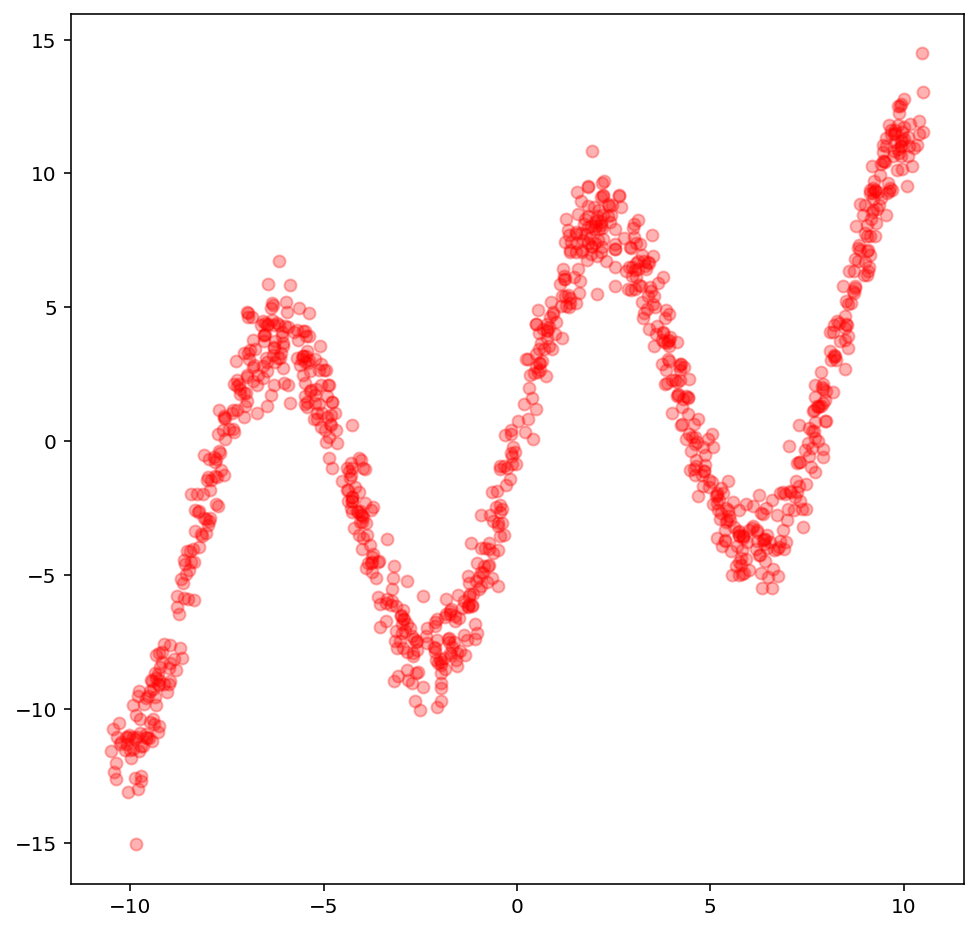

In [3]:
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

现在我们设计一个具有一个隐藏层的简单网络进行拟合，我们希望用神经网络模型设计一个函数 `y = f'(x)`，在一定区间上可以达到处处 `|f'(x) - f(x)| < ε`，这个表达式是 L1 的形式，可以直接当做我们的 loss 函数。当然，我们也可以使用 L2 （平方差）来设计我们的 loss 函数。

In [4]:
from graphviz import Digraph

dot = Digraph(comment='简单有效的网络')

dot.node('x')
dot.node('Hidden Layer')
dot.node('f(x)')

dot.edge('x', 'Hidden Layer')
dot.edge('Hidden Layer', 'f(x)')

dot.format = 'png'
dot.render('simple-regression.png')

dot

ModuleNotFoundError: No module named 'graphviz'

In [5]:
# 输入
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
# 需要逼近的目标值
y = tf.placeholder(dtype=tf.float32, shape=[None,1])

# 定义一个 20 个节点的隐藏层
hidden = tf.layers.dense(x, units=20, activation=tf.nn.tanh)
# 输出的预测值
y_out = tf.layers.dense(hidden, units=1, activation=None)

# 使用平方差的和作为损失值
loss = tf.nn.l2_loss(y_out - y)

# 定义优化器，目标是使损失值最小化
train_step = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)


# 初始化网络
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 训练 1000 轮
NEPOCH = 1000
for i in range(NEPOCH):
    sess.run(train_step, feed_dict={x: x_data, y: y_data})

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


现在我们看一下结果，其中蓝色是训练数据，红色是网络的输出值，可以看到，红色的点几乎完美地排成了一条阶段上升的曲线。

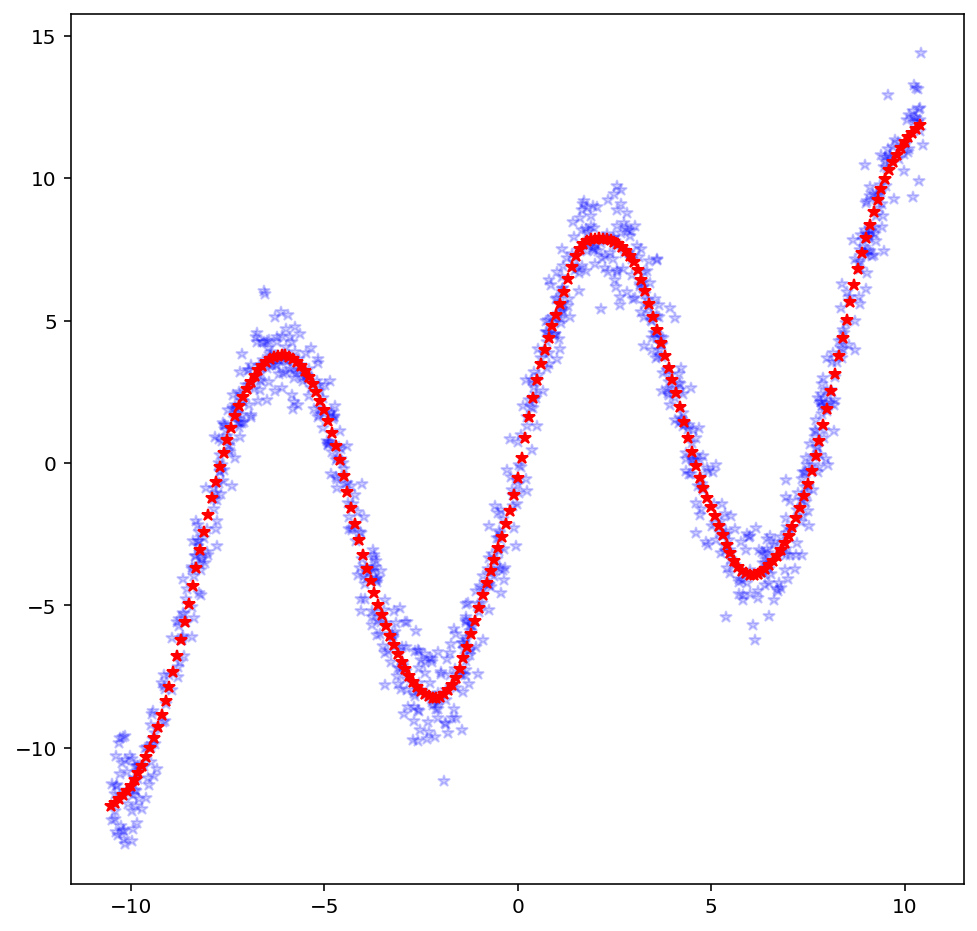

In [6]:
x_test = np.arange(-10.5, 10.5, 0.1)
x_test = np.reshape(x_test, newshape=(-1, 1))
y_test = sess.run(y_out, feed_dict={ x: x_test })

plt.figure(figsize=(8, 8))
plt.plot(x_data, y_data, 'b*', alpha=0.2)
plt.plot(x_test, y_test, 'r*')

plt.show()

## 交换数据点

现在我们进一步，将数据点的 x 轴与 y 轴交换，这样我们就有了一个多值函数的输入。在 python 中，交换两个轴的数据非常简单：

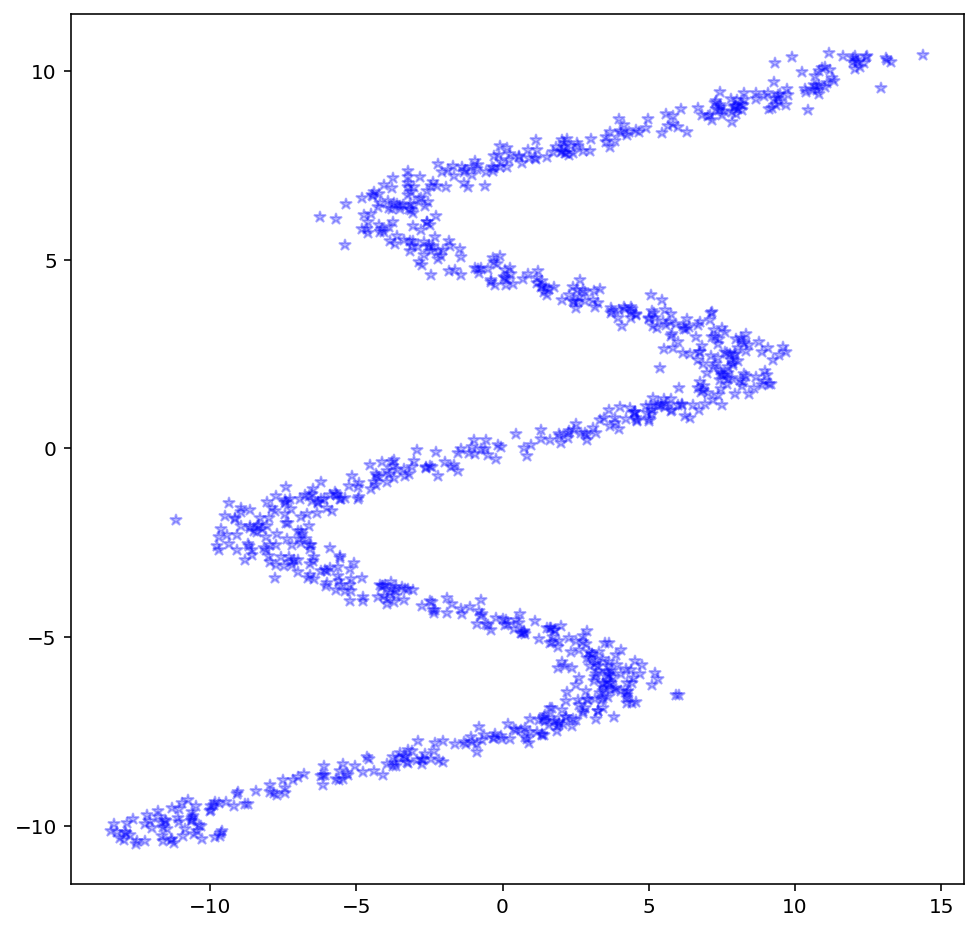

In [7]:
x_data, y_data = y_data, x_data
plt.figure(figsize=(8, 8))
plt.plot(x_data, y_data, 'b*', alpha=0.3)
plt.show()

现在我们的 x 可能会对应多个 y，如果再套用以前的方法，结果就不那么理想了。

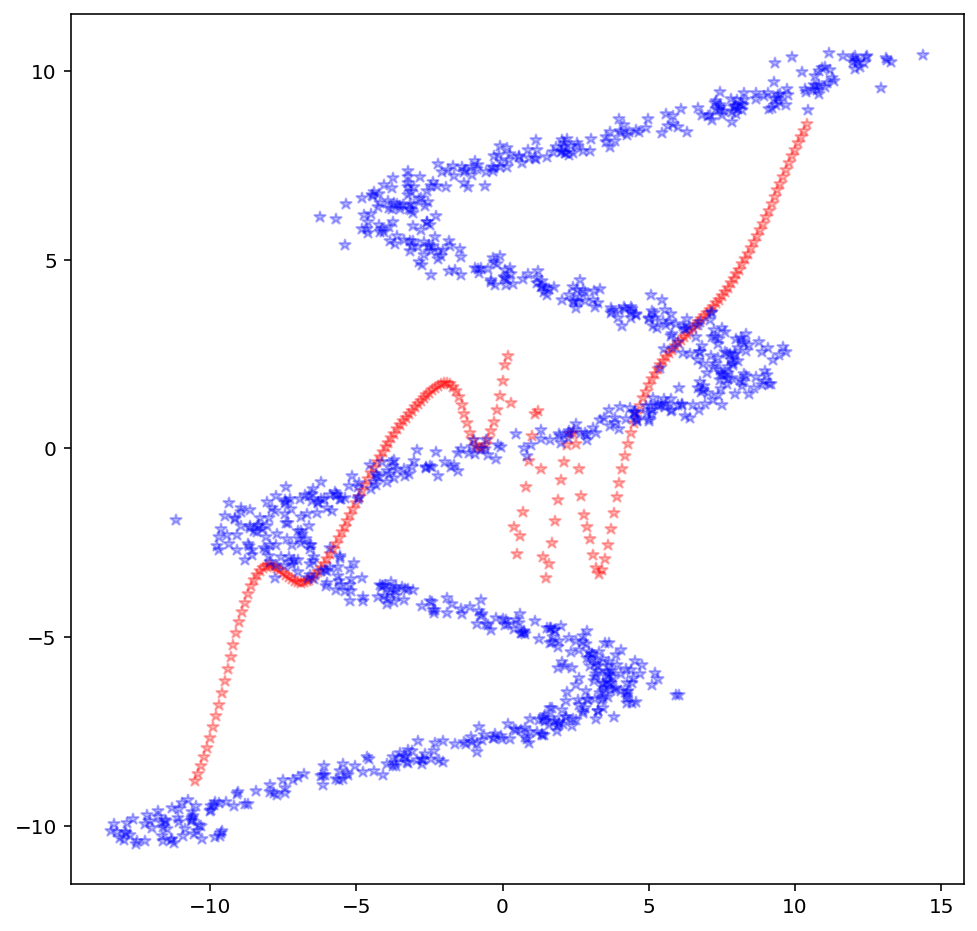

In [8]:
sess.run(tf.global_variables_initializer())

NEPOCH = 1000
for i in range(NEPOCH):
    sess.run(train_step, feed_dict={x: x_data, y: y_data})
    
x_test = np.arange(-10.5, 10.5, 0.1)
x_test = np.reshape(x_test, newshape=(-1, 1))
y_test = sess.run(y_out, feed_dict={ x: x_test })

plt.figure(figsize=(8, 8))
plt.plot(x_test, y_test, 'r*', x_data, y_data, 'b*', alpha=0.3)
plt.show()

是的，我们原来的模型已经失效了，无论增加多少层，增大多少节点数，都不能拟合多值函数曲线。所以，现在我们应该怎么办？

## 混合密度网络：薛定谔的猫

在前面的代码中，我们对于多值函数的预测走入了一个误区：我们的神经网络最后的输出是一个确定值，然而实际上我们需要的是多个『可能』的值。你也许会想，用神经网络输出多个值并不难呀，只要定义最后的输出层节点数大于 1 就可以了。是的，你可以定义一个多输出的网络（比如 3），然后每次输出 3 个预测值，然而这个网络的效果肯定是非常差的（你可以自己思考一下为什么）。

现在我们换一种思路——假如我们输出的不是一个值，而是目标值的一个『可能分布』，比如当 x=1 时，我们得到 y 有两个取值 { 1, -1 }，并且每个取值的概率都是 0.5。这就像薛定谔的那只量子叠加态的猫一样，我们得到的结果是一个概率分布，只有当我们进行一次『观察』时，才会得到一个具体结果！

使用这个思想设计的网络就叫混合密度网络(Mixture Density Network)，用处相当大。

你也许会问，概率究竟应该怎么表示呢，难道是输出一个类似 one-hot 表示的数组吗？显然我们不能使用 one-hot 来表示这个概率分布，因为我们输出的值域是连续的浮点数，我们不可能用有限的数组来表达。这里就要引入一个统计学里面的很常见的概念了，就是高斯分布。

高斯分布的概率密度曲线表示为：

这里面的参数只有两个，一个是均值 mu，一个是标准差 simga，通过改变这两个量，我们可以得到多样的概率分布曲线。

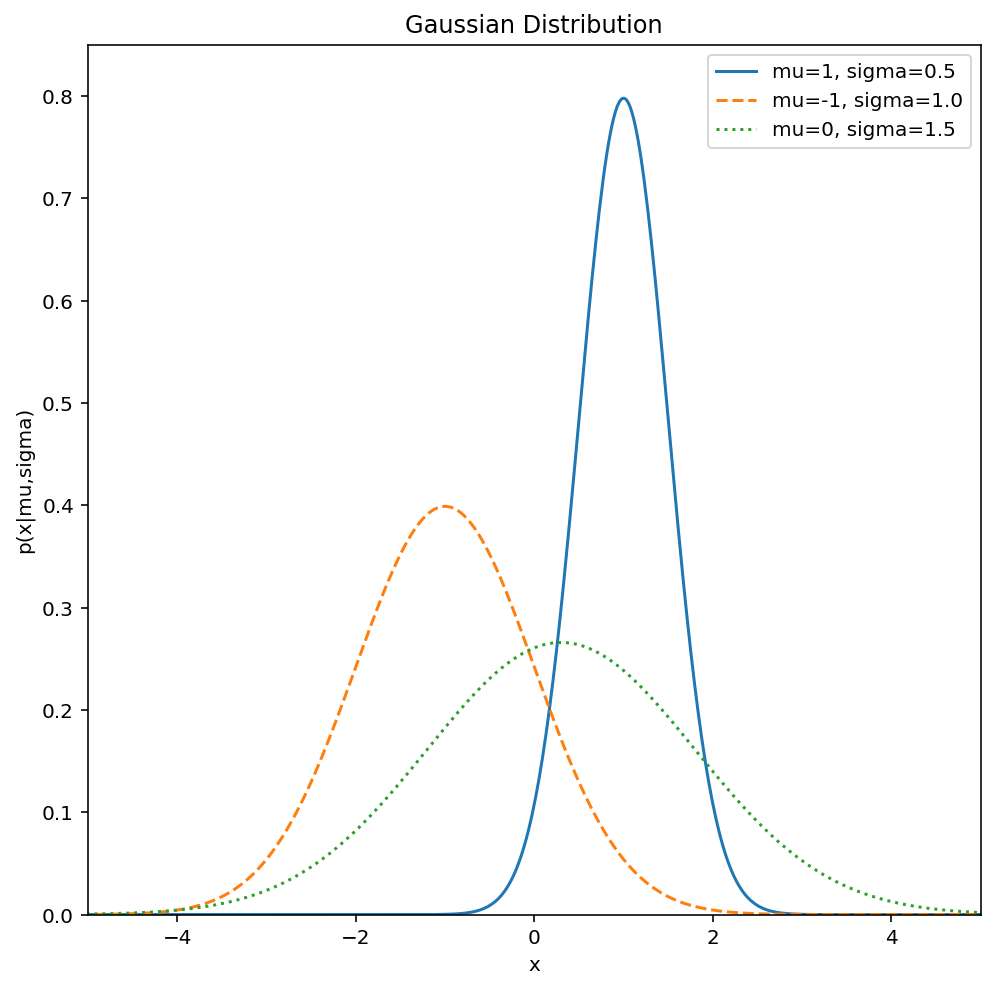

In [9]:
from scipy.stats import norm
sigma_values = [0.5, 1.0, 1.5]
linestyles = ['-', '--', ':']
mu_values = [1, -1, 0.3]
x = np.linspace(-10, 10, 1000)

plt.figure(figsize=(8, 8))

for mu, sigma, ls in zip(mu_values, sigma_values, linestyles):
    dist = norm(mu, sigma)

    plt.plot(x, dist.pdf(x), ls=ls,
             label='mu=%i, sigma=%.1f' % (mu, sigma))

plt.xlim(-5, 5)
plt.ylim(0, 0.85)

plt.xlabel('x')
plt.ylabel('p(x|mu,sigma)')
plt.title('Gaussian Distribution')

plt.legend()
plt.show()

而通过组合多个高斯概率分布，理论上我们可以逼近任意概率分布。比如将上面的三个分布按概率 1: 1: 1，混合为一个分布：

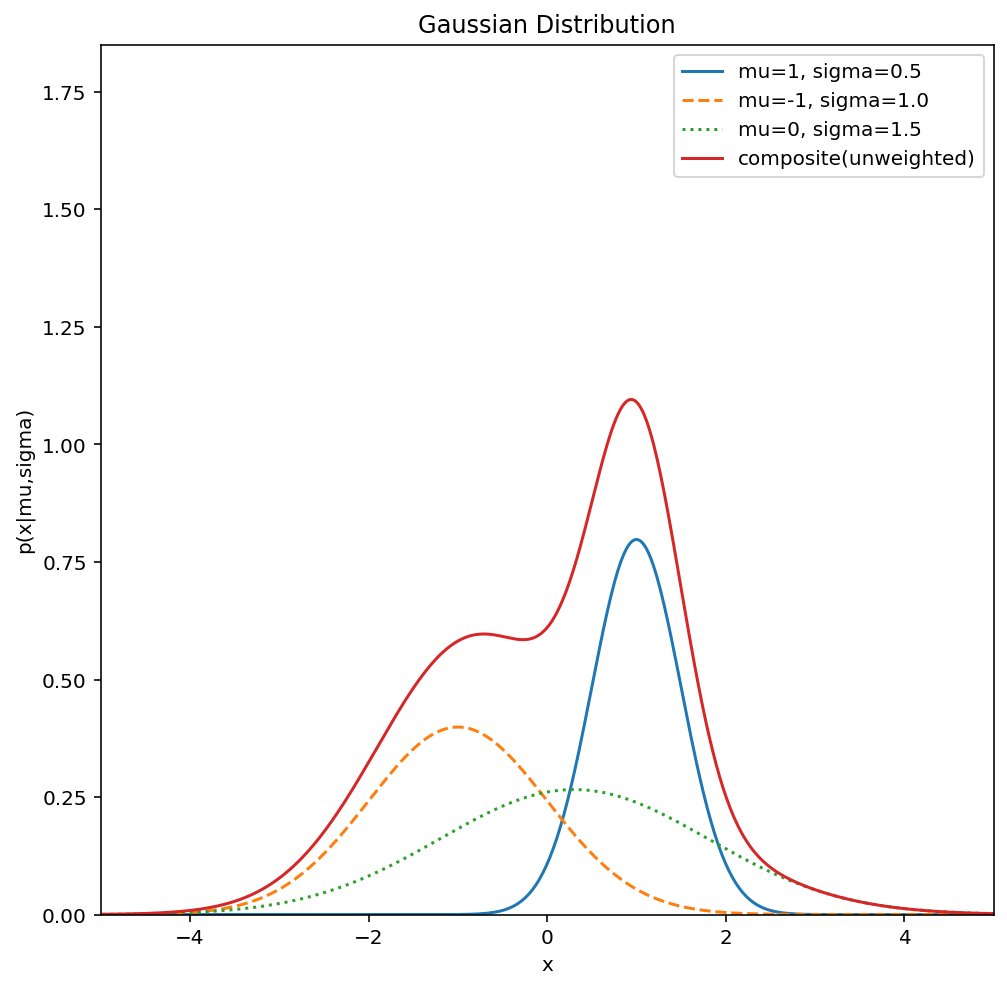

In [10]:
plt.figure(figsize=(8, 8))

composite = None
for mu, sigma, ls in zip(mu_values, sigma_values, linestyles):
    dist = norm(mu, sigma).pdf(x)
    plt.plot(x, dist, ls=ls,
             label='mu=%i, sigma=%.1f' % (mu, sigma))
    if composite is not None:
        composite += dist
    else:
        composite = dist

plt.plot(x, composite, label='composite(unweighted)')
plt.xlim(-5, 5)
plt.ylim(0, 1.85)

plt.xlabel('x')
plt.ylabel('p(x|mu,sigma)')
plt.title('Gaussian Distribution')

plt.legend()
plt.show()

所以我们的思路就比较清晰了：我们要设计这么一个网络，输入 x ，输出一个混合概率分布（即多个 mu 和 sigma 的组合值），而我们需要获取真正的预测值的时候，就从这么个混合概率分布中产生一个随机值，多次取随机值则可以得到所有 y 的可能值。混合概率网络的实现也很简单，我们设计一个具有两个隐藏层的网络，输出层节点数为 12 * 3 个，可以表示为 12 个高斯分布的叠加，我们用前 12 个节点表示 12 个高斯分布叠加时各自的权重，而中间 12 个表示平均数 mu，最后 12 个表示标准差 sigma。

In [11]:
tf.reset_default_graph()
x = tf.placeholder(shape=(None, 1), dtype=tf.float32, name='x')
y = tf.placeholder(shape=(None, 1), dtype=tf.float32, name='y')

mixture_size = 12
hidden1 = tf.layers.dense(x, units=64, activation=tf.nn.relu, name='hidden1')
hidden2 = tf.layers.dense(hidden1, units=128, activation=tf.nn.relu, name='hidden2')

out    = tf.layers.dense(hidden2, units=mixture_size * 3, activation=None, name='out')

# 平均分割为 3 部分
p, mu_out, sigma = tf.split(out, 3, 1)

# 使用 softmax 保证概率和为 1
p_out     = tf.nn.softmax(p, name='prob_dist')
# 使用 exp 保证标准差大于 0
sigma_out = tf.exp(sigma, name='sigma')

# 系数 1/(sqrt(2π))
factor = 1 / math.sqrt(2 * math.pi)
# 为了防止计算中可能出现除零的情况，当分母为零时，用一个极小值 epsilon 来代替
epsilon = 1e-5
tmp = - tf.square((y - mu_out)) / (2 * tf.square(tf.maximum(sigma_out, epsilon)))
y_normal = factor * tf.exp(tmp) / tf.maximum(sigma_out, epsilon)

我们的 loss 函数不能是和之前一样的平方差来表示，我们希望最大化真实的 y 值在混合概率密度中的概率，将经过标准化的 y_normal 与概率权重相乘，并取对数相加后取相反数，这个结果就是概率联合分布的最大似然函数。

In [12]:
loss = tf.reduce_sum(tf.multiply(y_normal, p_out), axis=1, keep_dims=True)
loss = -tf.log(tf.maximum(loss, epsilon))
loss = tf.reduce_mean(loss)
train_step = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


wow！完美，我们的混合密度网络真的拟合了这个多值函数，虽然有一点小瑕疵，实际上我自己通过增加节点数或者隐藏层后，生成的图像非常好，你也可以动手试试。

本文代码大量参考自[2]。如果对编程感兴趣，欢迎加入我们的讨论群：，一起学习魔法。

以上全文以及可视化代码已经制作成了 jupyter notebook 文件，可以关注公众号『代码律动codewaving』，回复 mdn 获取下载连接。

0/2500 loss: 8.206982612609863
500/2500 loss: 1.5285348892211914
1000/2500 loss: 1.487392544746399
1500/2500 loss: 1.492029070854187
2000/2500 loss: 1.4636077880859375


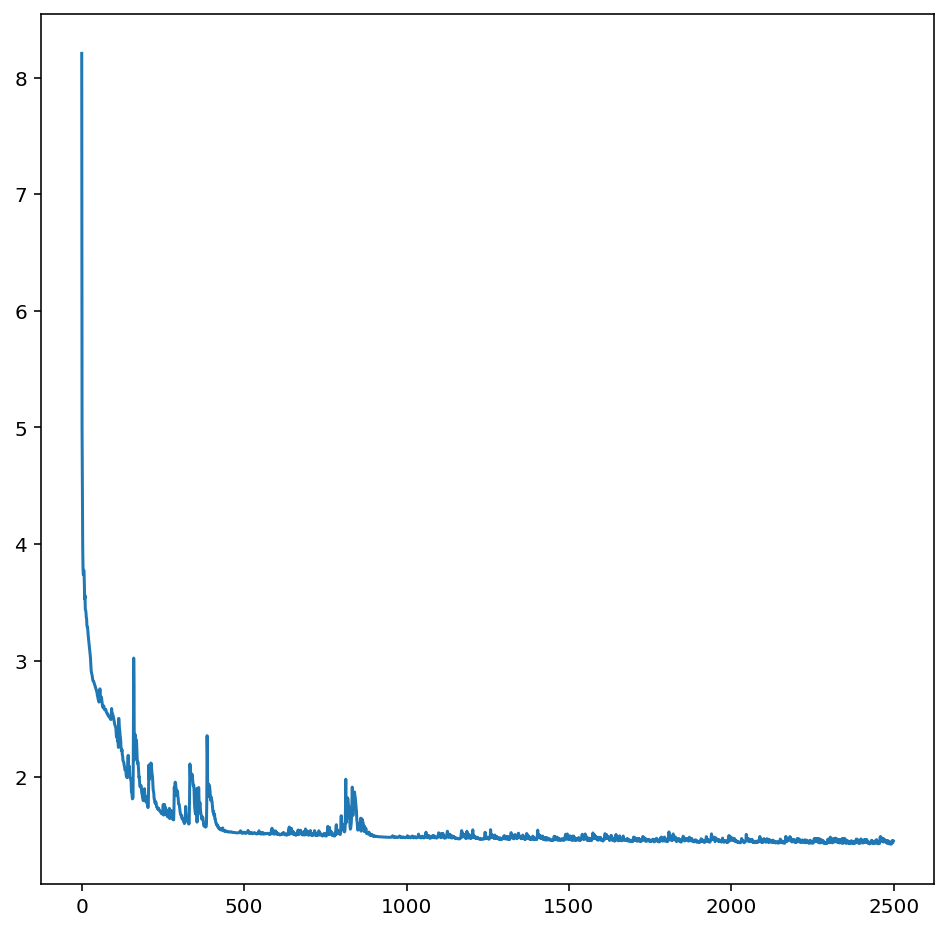

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

NEPOCH = 2500
loss_vals = np.zeros(NEPOCH)
for i in range(NEPOCH):
    _, loss_val = sess.run([train_step, loss], feed_dict={x : x_data, y: y_data})
    loss_vals[i] = loss_val
    if i % 500 == 0:
        print('{}/{} loss: {}'.format(i, NEPOCH, loss_val))

plt.figure(figsize=(8, 8))
plt.plot(loss_vals)
plt.show()

In [14]:
x_test = np.arange(-15, 15, 0.1)
x_test = np.reshape(x_test, newshape=(-1, 1))
p_val, sigma_val, mu_val = sess.run([p_out, sigma_out, mu_out], feed_dict={x: x_test})

生成数据测试一下，注意，由于我们得到的是一个概率分布，所以还需要根据预测出的联合概率密度来随机生成具体的点。在测试中，我们对于每一个输入 x 都成生 10 个随机点。最终得到的生成图像如下：

In [18]:
M = 10
x_pred = np.repeat(x_test, M)

NTEST = len(x_test)
y_pred = np.random.rand(NTEST, M)
rn = np.random.randn(NTEST, M)

def get_pi_idx(x, pdf):
    N = pdf.size
    acc = 0
    for i in range(0, N):
        acc += pdf[i]
        if acc >= x:
            return i

for j in range(M):
    for i in range(NTEST):
        idx = get_pi_idx(y_pred[i, j], p_val[i])
        mu  = mu_val[i, idx]
        std = sigma_val[i, idx]
        y_pred[i, j] = mu + rn[i, j]*std

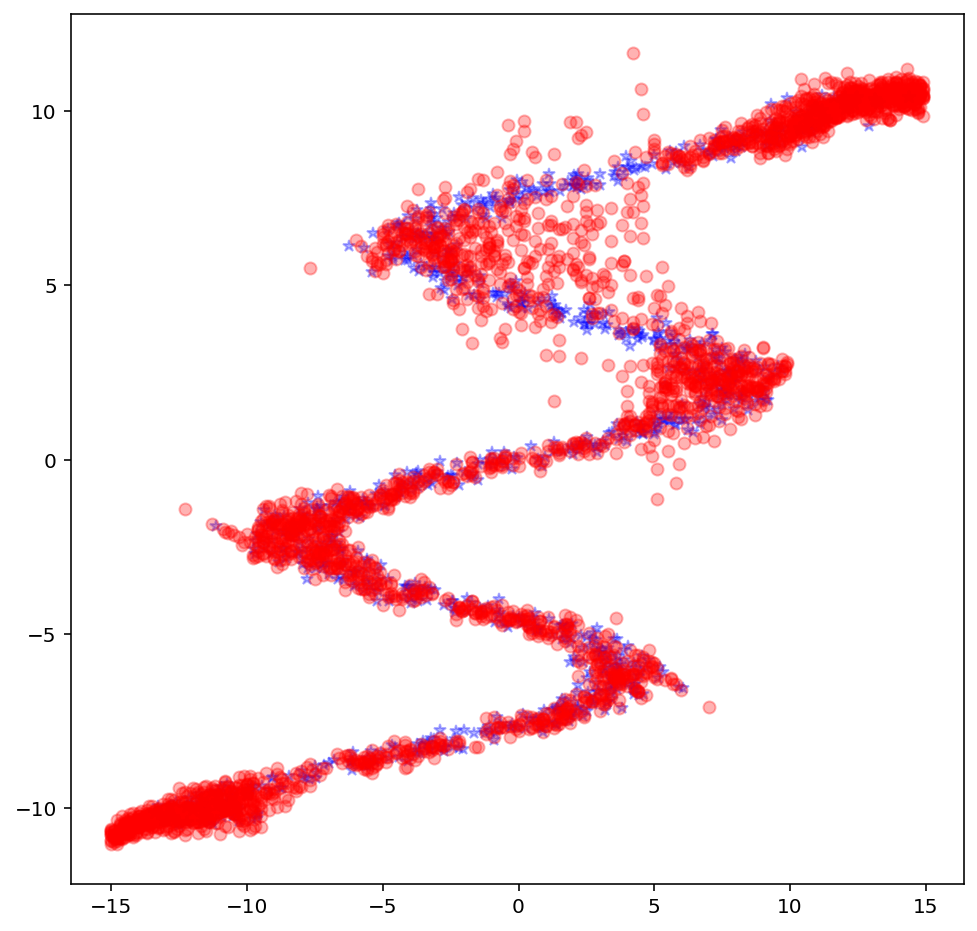

In [19]:
plt.figure(figsize=(8, 8))
plt.plot(x_data, y_data, 'b*', x_test, y_pred, 'ro', alpha=0.3)
plt.show()

[1] https://zh.wikipedia.org/wiki/%E5%A4%9A%E5%80%BC%E5%87%BD%E6%95%B0

[2] http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/